# INFORMATION RETRIEVAL AND QUESTION ANSWERING 


**1. IMPORT THE LIBRARY USED**

In [7]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KDTree
import re
import matplotlib.pyplot as plt
import seaborn as sns

**2. LOAD THE DATASET**

In [8]:
data = pd.read_csv('news_dataset.csv', encoding='ISO-8859-1')
data

,id,author,date,year,month,topic,article
0,17307,Marlise Simons,1/01/2017,2017,1,architecture,PARIS ? When the Islamic State was about to...
1,17292,Andy Newman,31/12/2016,2016,12,art,Angels are everywhere in the Mu?iz family?s ap...
2,17298,Emma G. Fitzsimmons,2/01/2017,2017,1,business,Finally. The Second Avenue subway opened in Ne...
3,17311,Carl Hulse,3/01/2017,2017,1,business,WASHINGTON ? It?s or time for Republica...
4,17339,Jim Rutenberg,5/01/2017,2017,1,business,"For Megyn Kelly, the shift from Fox News to NB..."
...,...,...,...,...,...,...,...
995,18460,Gerry Mullany,14/03/2017,2017,3,accidents,HONG KONG ? Hundreds of pilot whales that s...
996,18461,Rory Smith,10/02/2017,2017,2,sports,"NICE, France ? Riv?re accepts the complim..."
997,18462,Jack Ewing,9/02/2017,2017,2,business,FRANKFURT ? Germans who never really warmed...
998,18463,Scott Cacciola,10/02/2017,2017,2,sports,Charles Oakley has strong feelings about compe...


**3. PREPROCESSING**

In [9]:
import textwrap
wrapper = textwrap.TextWrapper(width=100)

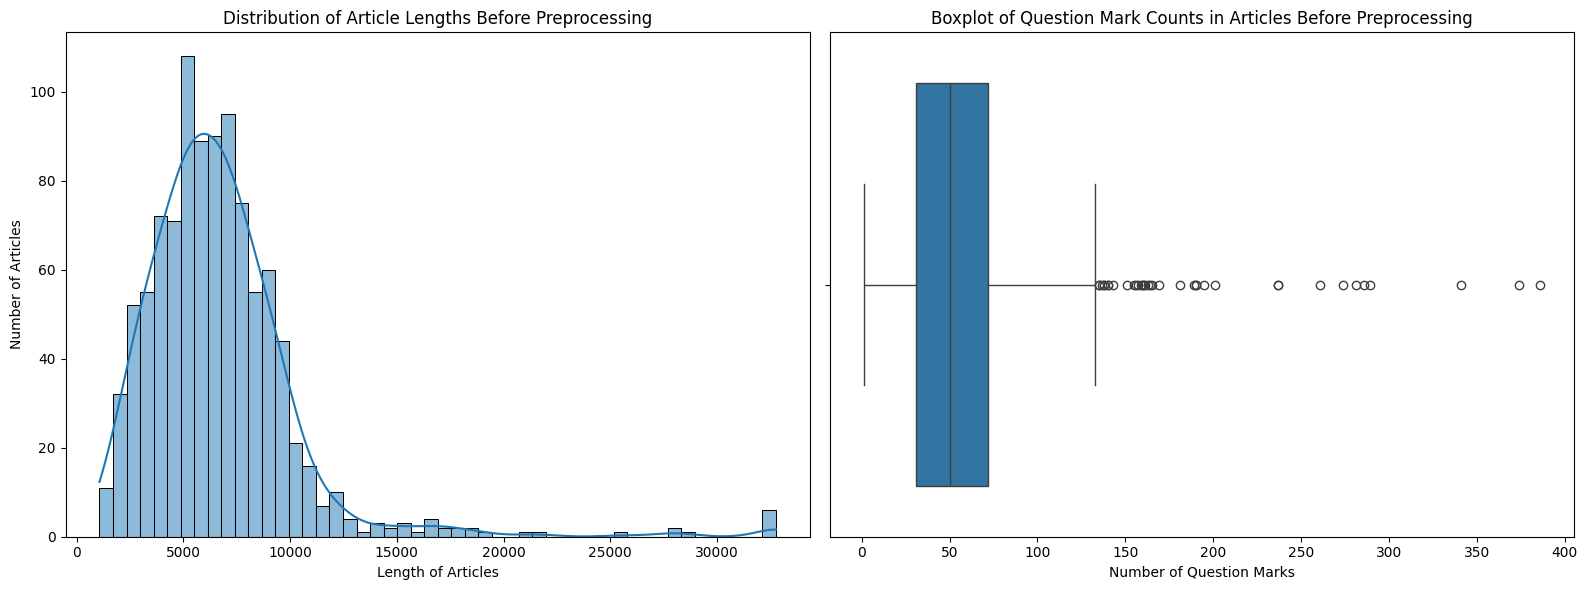

(count     1000.000000
 mean      6679.682000
 std       3733.730668
 min       1074.000000
 25%       4476.750000
 50%       6241.500000
 75%       8040.000000
 max      32759.000000
 Name: length_before, dtype: float64,
 count    1000.000000
 mean       56.600000
 std        40.014237
 min         1.000000
 25%        31.000000
 50%        50.000000
 75%        72.000000
 max       386.000000
 Name: question_marks_before, dtype: float64)

In [10]:
import numpy as np

# Create a new column 'length_before' which is the length of the article before preprocessing
data['length_before'] = data['article'].apply(len)

# Create a new column 'question_marks_before' which is the count of question marks before preprocessing
data['question_marks_before'] = data['article'].apply(lambda x: x.count('?'))

# Plotting
plt.figure(figsize=(16, 6))

# Distribution of article lengths
plt.subplot(1, 2, 1)
sns.histplot(data['length_before'], bins=50, kde=True)
plt.title('Distribution of Article Lengths Before Preprocessing')
plt.xlabel('Length of Articles')
plt.ylabel('Number of Articles')

# Distribution of question mark counts
plt.subplot(1, 2, 2)
sns.boxplot(x=data['question_marks_before'])
plt.title('Boxplot of Question Mark Counts in Articles Before Preprocessing')
plt.xlabel('Number of Question Marks')

plt.tight_layout()
plt.show()

# Descriptive statistics of the article lengths and question mark counts
length_stats = data['length_before'].describe()
question_mark_stats = data['question_marks_before'].describe()

(length_stats, question_mark_stats)

Distribution of Article Lengths Before Preprocessing: The histogram shows the distribution of article lengths, measured by the number of characters. The articles vary significantly in length, with most having between 4,000 and 8,000 characters. The distribution is right-skewed, meaning there are some exceptionally long articles.

An average length of about 6,680 characters,
A standard deviation of around 3,734, indicating variability in article length,
A minimum length of 1,074 characters,
And a maximum length of 32,759 characters.


Boxplot of Question Mark Counts in Articles Before Preprocessing: This boxplot displays the distribution of the number of question marks in the articles. The median number of question marks is around 50, with a significant number of articles containing more, as indicated by the upper whisker and outliers.

An average count of approximately 57 question marks per article,
A standard deviation of around 40, showing variability in their usage,
A minimum count of 1 question mark,
And a maximum count of 386 question marks.

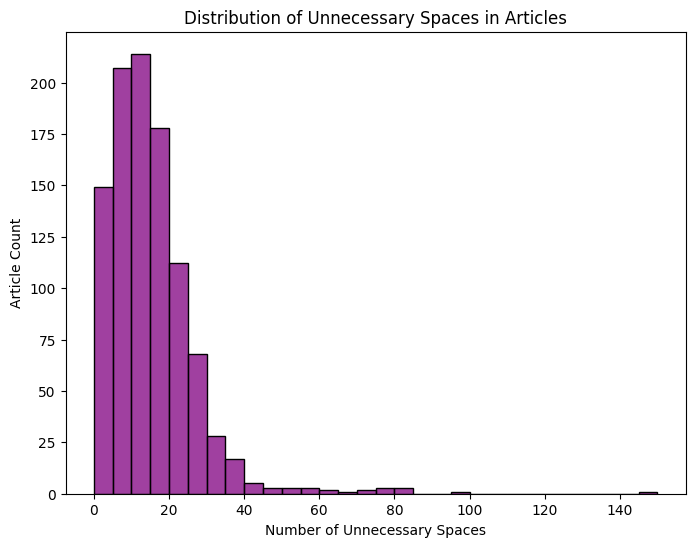

count    1000.000000
mean       14.859000
std        12.299203
min         0.000000
25%         7.000000
50%        13.000000
75%        20.000000
max       150.000000
Name: unnecessary_spaces, dtype: float64

In [11]:
# Define a function to count unnecessary spaces around punctuation
def count_unnecessary_spaces(text):
    # Count spaces before commas or periods
    spaces_before_commas = len(re.findall(r'\s,', text))
    spaces_before_periods = len(re.findall(r'\s\.', text))
    # Count spaces after periods where it is not followed by a digit or letter (considered likely unnecessary)
    spaces_after_periods = len(re.findall(r'\.\s(?![0-9A-Za-z])', text))
    return spaces_before_commas + spaces_before_periods + spaces_after_periods

# Apply the function to the original articles
data['unnecessary_spaces'] = data['article'].apply(count_unnecessary_spaces)

# Plot the distribution of unnecessary spaces
plt.figure(figsize=(8, 6))
sns.histplot(data['unnecessary_spaces'], bins=30, kde=False, color='purple')
plt.title('Distribution of Unnecessary Spaces in Articles')
plt.xlabel('Number of Unnecessary Spaces')
plt.ylabel('Article Count')
plt.show()

# Return the statistics for unnecessary spaces
data['unnecessary_spaces'].describe()

The histogram illustrates the distribution of unnecessary spaces in the articles. Unnecessary spaces are defined here as spaces occurring before commas or periods, and after periods where they are not followed by a digit or letter. This plot shows that:

The number of unnecessary spaces varies across articles, with a mean of approximately 15 spaces per article.
Most articles have between 7 and 20 unnecessary spaces, based on the 25th and 75th percentiles.
There are some articles with a significantly higher count of unnecessary spaces, with the maximum reaching up to 150.

In [12]:

import pandas as pd
import re

def preprocess_text(text):
    #Removing the ?
    text = re.sub(r'\?', '', text)
    text = re.sub(r'no\. (\d+)', r'no.\1', text)

    a = r'(\d+)\.\s(\d+)'
    b = r'\1.\2'
    text = re.sub(a, b, text)
    text = text.lower()
    return " ".join(text.split())  # Joining tokens back into a string for compatibility with Transformers

# Applying function
data['processed_article'] = data['article'].apply(preprocess_text)


article = data.loc[data['id'] == 17294, 'processed_article'].iloc[0]
print(wrapper.fill(article))


thompsons, tex. can one of the most promising and troubled technologies for fighting global warming
survive during the administration of donald j. trump the technology, carbon capture, involves
pulling carbon dioxide out of smokestacks and industrial processes before the gas can make its way
into the atmosphere. mr. trumps denial of the overwhelming scientific evidence supporting climate
change, a view shared by many of his cabinet nominees, might appear to doom any such environmental
initiatives. but the new petra nova plant about to start running here, about 30 miles southwest of
houston, is a bright spot for the technologys supporters. it is being completed essentially on time
and within its budget, unlike many previous such projects. when it fires up, the plant, which is
attached to one of the power company nrgs hulking units, will draw 90 percent of the co2 from the
emissions produced by 240 megawatts of generated power. that is a fraction of the roughly 3, 700
megawatts produced 

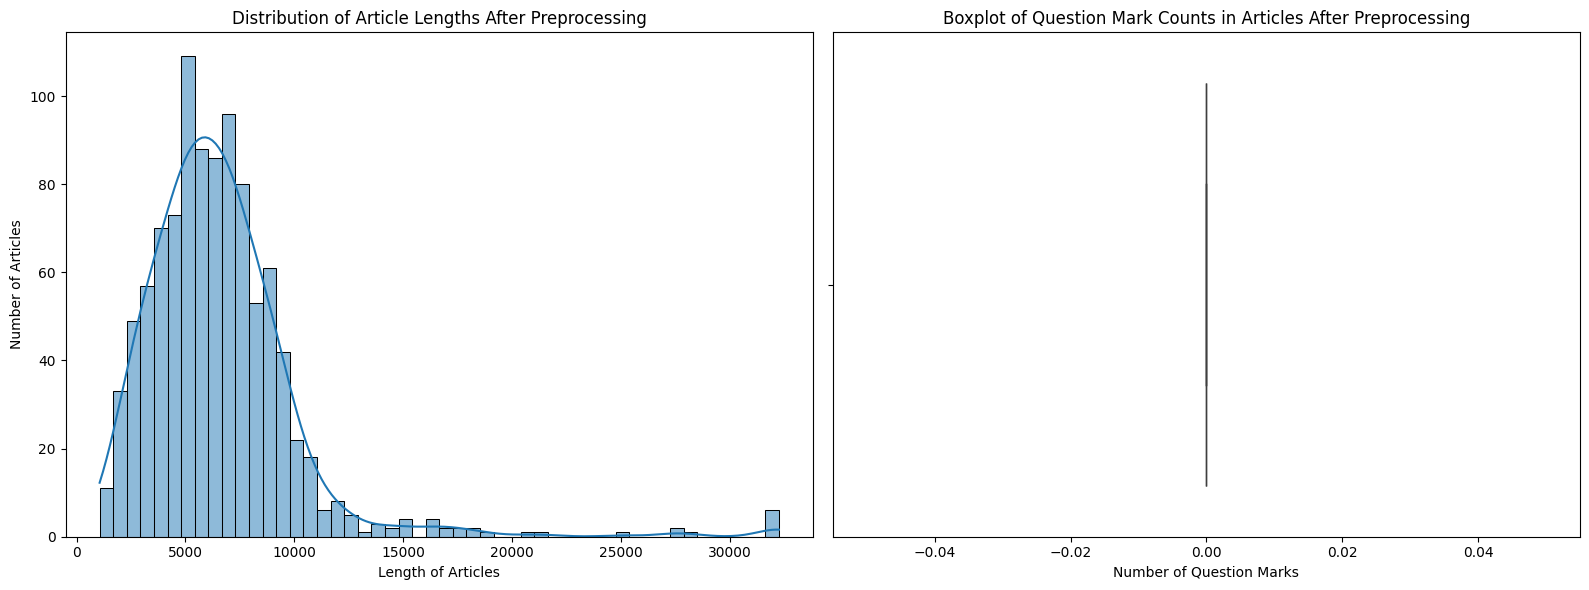

(count     1000.00000
 mean      6578.86700
 std       3672.63534
 min       1056.00000
 25%       4409.75000
 50%       6137.00000
 75%       7915.75000
 max      32266.00000
 Name: length_after, dtype: float64,
 count    1000.0
 mean        0.0
 std         0.0
 min         0.0
 25%         0.0
 50%         0.0
 75%         0.0
 max         0.0
 Name: question_marks_after, dtype: float64)

In [13]:
# Create new columns for the length of the article and the count of question marks after preprocessing
data['length_after'] = data['processed_article'].apply(len)
data['question_marks_after'] = data['processed_article'].apply(lambda x: x.count('?'))

# Plotting
plt.figure(figsize=(16, 6))

# Distribution of article lengths after preprocessing
plt.subplot(1, 2, 1)
sns.histplot(data['length_after'], bins=50, kde=True)
plt.title('Distribution of Article Lengths After Preprocessing')
plt.xlabel('Length of Articles')
plt.ylabel('Number of Articles')

# Distribution of question mark counts after preprocessing
plt.subplot(1, 2, 2)
sns.boxplot(x=data['question_marks_after'])
plt.title('Boxplot of Question Mark Counts in Articles After Preprocessing')
plt.xlabel('Number of Question Marks')

plt.tight_layout()
plt.show()

# Descriptive statistics of the article lengths and question mark counts after preprocessing
length_stats_after = data['length_after'].describe()
question_mark_stats_after = data['question_marks_after'].describe()

(length_stats_after, question_mark_stats_after)

Distribution of Article Lengths After Preprocessing: The histogram displays the length of articles after preprocessing, which still exhibits a right-skewed distribution. The articles typically range from 4,000 to 8,000 characters in length, with a decrease in length from before preprocessing due to the removal of characters (such as question marks and extra spaces).

Boxplot of Question Mark Counts in Articles After Preprocessing: Since the preprocessing function was designed to remove all question marks, the boxplot shows that there are now zero question marks in all articles.
The descriptive statistics post-preprocessing are as follows:

For article length, the average is now about 6,579 characters, a slight reduction from before, due to the removal of certain characters during preprocessing.

The standard deviation has decreased slightly to around 3,673, indicating a small decrease in variability of article length.
The minimum length of articles is now 1,056 characters, and the maximum is 32,266 characters.

As for question mark counts, they are now all zero across the dataset, confirming the effectiveness of the preprocessing step in removing question marks.

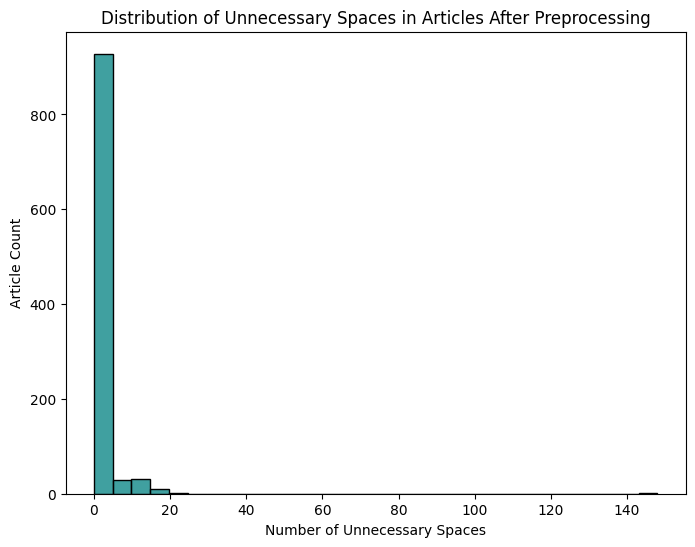

count    1000.000000
mean        1.472000
std         5.450222
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       148.000000
Name: unnecessary_spaces_after, dtype: float64

In [14]:
# Apply the function to count unnecessary spaces in the preprocessed articles
data['unnecessary_spaces_after'] = data['processed_article'].apply(count_unnecessary_spaces)

# Plot the distribution of unnecessary spaces after preprocessing
plt.figure(figsize=(8, 6))
sns.histplot(data['unnecessary_spaces_after'], bins=30, kde=False, color='teal')
plt.title('Distribution of Unnecessary Spaces in Articles After Preprocessing')
plt.xlabel('Number of Unnecessary Spaces')
plt.ylabel('Article Count')
plt.show()

# Return the statistics for unnecessary spaces after preprocessing
data['unnecessary_spaces_after'].describe()

The average number of unnecessary spaces has decreased to about 1.47 per article, a substantial improvement from before preprocessing.

The distribution is heavily skewed towards zero, with the majority of articles now having no unnecessary spaces at all.

While there is a marked improvement, there are still a few articles with a higher count of unnecessary spaces, with the maximum reaching up to 148, indicating that some specific cases might require additional rules in the preprocessing to handle.

**4. Coreference Resolution utility**

In [ ]:
pip install neuralcoref

In [ ]:
import neuralcoref
import spacy


In [ ]:
def resolve_coreference_utility(text):
    nlp=spacy.load('en_core_web_sm')
    neuralcoref.add_to_pipe(nlp)
    doc = nlp(text)

    return doc._.coref_resolved

**5. Text matching utility**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def identify_relevant_article_segments(text, query, min_similarity):
    # Splitting the provided text into its constituent sentences.
    article_sentences = nltk.sent_tokenize(text)
    
    # Setting up the TF-IDF vectorization process for the query and the article sentences.
    tfidf = TfidfVectorizer()
    vectors = tfidf.fit_transform([query] + article_sentences)
    
    # Executing cosine similarity calculation to find relevance scores between the query and sentences.
    relevance_scores = cosine_similarity(vectors[0:1], vectors[1:]).flatten()
    
    # Identifying sentences that meet or exceed the relevance threshold.
    indexes_of_interest = np.where(relevance_scores > min_similarity)[0]
    
    # Collecting sentences and their scores that are above the threshold.
    sentence_score_pairs = [(article_sentences[index], relevance_scores[index]) for index in indexes_of_interest]
    
    # Ordering the collected sentences by their relevance scores in descending order.
    ordered_relevant_sentences = sorted(sentence_score_pairs, key=lambda pair: pair[1], reverse=True)
    
    # Restricting the result to the top sentences if necessary.
    top_relevant_sentences = ordered_relevant_sentences[:min(len(ordered_relevant_sentences), 4)]

    
    return [p[0] for p in top_relevant_sentences]


In [ ]:
pip install torch torchvision torchaudio


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [ ]:
import torch
print(torch.__version__)

2.2.2+cpu


**6. INFORMATION SYSTEM APPLICATION**

In [ ]:
import torch
from transformers import BertForQuestionAnswering, BertTokenizer
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

c:\Users\DELL\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

def retrieve_answer(question_text, context):
    # Specify the pre-trained model to use.
    pretrained_model = "distilbert-base-cased-distilled-squad"
    
    # Load the tokenizer and model using the specified pre-trained model.
    qa_tokenizer = AutoTokenizer.from_pretrained(pretrained_model)
    qa_model = AutoModelForQuestionAnswering.from_pretrained(pretrained_model)

    # Utilize the tokenizer to prepare the inputs for the model.
    tokenized_inputs = qa_tokenizer(question_text, context, return_tensors='pt', 
                                     max_length=512, truncation=True, 
                                     truncation_strategy='only_second')
    tokens_tensor = tokenized_inputs['input_ids']
    mask_tensor = tokenized_inputs['attention_mask']

    # Feed the tokenized input into the question-answering model.
    model_output = qa_model(tokens_tensor, attention_mask=mask_tensor, return_dict=True)
    start_scores = model_output.start_logits
    end_scores = model_output.end_logits

    # Find the tokens corresponding to the start and end of the answer.
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores) + 1

    # Convert IDs to tokens and extract the answer tokens.
    tokens_list = qa_tokenizer.convert_ids_to_tokens(tokens_tensor[0])
    answer_ids = tokens_tensor[0][answer_start:answer_end]
    processed_answer = qa_tokenizer.decode(answer_ids)

    # Remove tokens that should not be part of the final answer.
    clean_answer_ids = [id for i, id in enumerate(answer_ids) if id not in [qa_tokenizer.cls_token_id, qa_tokenizer.sep_token_id]]

    # Decode the cleaned answer IDs to form the final answer text.
    final_answer = qa_tokenizer.decode(clean_answer_ids).strip()

    # Output the final answer.
    if final_answer:
        print("Answer: " + final_answer)
        return final_answer
    else:
        return ""


In [ ]:
import torch
from transformers import BertForQuestionAnswering, BertTokenizer

def get_answer_with_bert(question_text, passage_text):
    # Load the pre-trained BERT model and tokenizer specialized for question-answering tasks.
    bert_model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
    bert_tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

    # Tokenization: Encode both the question and the passage to numerical IDs.
    tokens_ids = bert_tokenizer.encode(question_text, passage_text)

    # Identify the `[SEP]` token's index, splitting question and passage tokens.
    sep_token_idx = tokens_ids.index(bert_tokenizer.sep_token_id)

    # Segment IDs: Assign 0s to question tokens and 1s to passage tokens, including `[SEP]` token in question segment.
    seg_ids = [0] * (sep_token_idx + 1) + [1] * (len(tokens_ids) - sep_token_idx - 1)

    # Confirm matching lengths of tokens and segment IDs.
    assert len(seg_ids) == len(tokens_ids)

    # Model Inference: Pass encoded tokens and segment IDs to the model to obtain start and end logits.
    output_scores = bert_model(input_ids=torch.tensor([tokens_ids]),
                               token_type_ids=torch.tensor([seg_ids]))
    start_logits = output_scores.start_logits
    end_logits = output_scores.end_logits

    # Identify the positions for the start and end of the answer.
    answer_start_idx = torch.argmax(start_logits)
    answer_end_idx = torch.argmax(end_logits) + 1

    # Decode tokens back to string and assemble the answer.
    answer_tokens = bert_tokenizer.convert_ids_to_tokens(tokens_ids[answer_start_idx:answer_end_idx])
    assembled_answer = bert_tokenizer.convert_tokens_to_string(answer_tokens)

    # Display and return the answer.
    if assembled_answer:
        print("Answer:", assembled_answer.strip())
        return assembled_answer.strip()
    else:
        print("No answer found!")
        return ""


In [ ]:
def fetch_answer_from_article(article_content, query, min_confidence=0.1, use_bert=True):

    cleaned_article = preprocess_text(article_content)
    
    coherent_article = resolve_coreference_utility(cleaned_article)

    relevant_sentences= identify_relevant_article_segments(coherent_article, query, min_confidence)
  
    # If relevant sentences are found, attempt to extract the answer using the selected model.
    if relevant_sentences:
        concatenated_sentences = " ".join(relevant_sentences)
        if not use_bert:
            return retrieve_answer(query, concatenated_sentences)
        else:
            return get_answer_with_bert(query, concatenated_sentences)
    else:
        print("No answer found!")
        return ""


In [ ]:
article_id = 17904
query = """What is the setting for the film "Lion"?"""
article = data.loc[data['id'] == article_id, 'article'].iloc[0]
answer = fetch_answer_from_article(article, query, min_confidence=0.1, use_bert=True)


Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Answer: india


**7. FETCH ANSWER**

In [ ]:
while True:
    article_id = int(input("Please enter the article ID (or type 'quit' to exit): "))
    
    query = input("Please enter your query: ")
    
    if article_id in data['id'].values:
        print("Article found. Processing query...")
        article = data.loc[data['id'] == article_id, 'article'].iloc[0]
        break
    else:
        print("The ID not founded")

answer = fetch_answer_from_article(article, query, min_confidence=0.1, use_bert=True)


Article found. Processing query...
Answer: jay y . lee


**8. Evaluation - TESTING**

In [ ]:
def calculate_mrr(provided_answers, correct_answers):
    if not provided_answers or not correct_answers:
        return 0.0  

    provided_answers_lower = provided_answers.lower()
    correct_answers_lower = [answer.lower() for answer in correct_answers]
    ranks = []

    mrr= 0.0
    for i, correct_answer in enumerate(correct_answers_lower):
        if provided_answers_lower == correct_answer:
            mrr = 1 / (i+1)
            break

    return mrr



def calculate_map(provided_answers, correct_answer_lists):
    average_precisions = []

    provided_answers_lower = provided_answers.lower()
    correct_answers_lower = [answer.lower() for answer in correct_answer_lists]

    hit_count = 0
    for i, correct_answer in enumerate(correct_answers_lower):
        precisions = []
        
        if provided_answers_lower == correct_answer:
            hit_count += 1
            precision = hit_count / (i + 1)  # Calculate precision at this rank
            precisions.append(precision)
            # print(precisions)

        if precisions:
            average_precision = sum(precisions) / len(precisions)
            average_precisions.append(average_precision)
            # print(average_precision)

    # Calculate the MAP score across all queries
    map_score = sum(average_precisions) / len(average_precisions) if average_precisions else 0.0
    return map_score

In [ ]:
def get_MRR_and_MAP_score(answerlist, correct_answerslist):
    mrr_scores = [calculate_mrr(answer, correct_answers) for answer, correct_answers in zip(answerlist, correct_answerslist)]
    mean_mrr = sum(mrr_scores) / len(mrr_scores) if mrr_scores else 0.0
    map_score = [calculate_map(answer, correct_answers) for answer, correct_answers in zip(answerlist, correct_answerslist)]
    mean_map = sum(map_score) / len(map_score) if map_score else 0.0
    return mean_mrr, mean_map


**Evaluation**

In [ ]:
# Sample use
# Question from SQUAD 
articles_diction = {"article_content_1": {"text":"Steam engines are external combustion engines, where the working fluid is separate from the combustion products. Non-combustion heat sources such as solar power, nuclear power or geothermal energy may be used. The ideal thermodynamic cycle used to analyze this process is called the Rankine cycle. In the cycle, water is heated and transforms into steam within a boiler operating at a high pressure. When expanded through pistons or turbines, mechanical work is done. The reduced-pressure steam is then condensed and pumped back into the boiler.", "question":"At what pressure is water heated in the Rankine cycle?"},
    "article_content_2": {"text":"Steam engines are external combustion engines, where the working fluid is separate from the combustion products. Non-combustion heat sources such as solar power, nuclear power or geothermal energy may be used. The ideal thermodynamic cycle used to analyze this process is called the Rankine cycle. In the cycle, water is heated and transforms into steam within a boiler operating at a high pressure. When expanded through pistons or turbines, mechanical work is done. The reduced-pressure steam is then condensed and pumped back into the boiler.", "question":"What ideal thermodynamic cycle analyzes the process by which steam engines work?"},
    "article_content_3": {"text":"""Oxygen is a chemical element with symbol O and atomic number 8. It is a member of the chalcogen group on the periodic table and is a highly reactive nonmetal and oxidizing agent that readily forms compounds (notably oxides) with most elements. By mass, oxygen is the third-most abundant element in the universe, after hydrogen and helium. At standard temperature and pressure, two atoms of the element bind to form dioxygen, a colorless and odorless diatomic gas with the formula O2. Diatomic oxygen gas constitutes 20.8% of the Earth's atmosphere. However, monitoring of atmospheric oxygen levels show a global downward trend, because of fossil-fuel burning. Oxygen is the most abundant element by mass in the Earth's crust as part of oxide compounds such as silicon dioxide, making up almost half of the crust's mass.""", "question":"The atomic number of the periodic table for oxygen?"},
    "article_content_4": {"text":"""Oxygen is a chemical element with symbol O and atomic number 8. It is a member of the chalcogen group on the periodic table and is a highly reactive nonmetal and oxidizing agent that readily forms compounds (notably oxides) with most elements. By mass, oxygen is the third-most abundant element in the universe, after hydrogen and helium. At standard temperature and pressure, two atoms of the element bind to form dioxygen, a colorless and odorless diatomic gas with the formula O2. Diatomic oxygen gas constitutes 20.8% of the Earth's atmosphere. However, monitoring of atmospheric oxygen levels show a global downward trend, because of fossil-fuel burning. Oxygen is the most abundant element by mass in the Earth's crust as part of oxide compounds such as silicon dioxide, making up almost half of the crust's mass.""", "question":"What is the second most abundant element?"},
    "article_content_5": {"text":"""Oxygen is a chemical element with symbol O and atomic number 8. It is a member of the chalcogen group on the periodic table and is a highly reactive nonmetal and oxidizing agent that readily forms compounds (notably oxides) with most elements. By mass, oxygen is the third-most abundant element in the universe, after hydrogen and helium. At standard temperature and pressure, two atoms of the element bind to form dioxygen, a colorless and odorless diatomic gas with the formula O2. Diatomic oxygen gas constitutes 20.8% of the Earth's atmosphere. However, monitoring of atmospheric oxygen levels show a global downward trend, because of fossil-fuel burning. Oxygen is the most abundant element by mass in the Earth's crust as part of oxide compounds such as silicon dioxide, making up almost half of the crust's mass.""", "question":"What type of compounds does oxygen most commonly form?"},
    "article_content_6": {"text":"""The Yuan dynasty (Chinese: 元朝; pinyin: Yuán Cháo), officially the Great Yuan (Chinese: 大元; pinyin: Dà Yuán; Mongolian: Yehe Yuan Ulus[a]), was the empire or ruling dynasty of China established by Kublai Khan, leader of the Mongolian Borjigin clan. Although the Mongols had ruled territories including today's North China for decades, it was not until 1271 that Kublai Khan officially proclaimed the dynasty in the traditional Chinese style. His realm was, by this point, isolated from the other khanates and controlled most of present-day China and its surrounding areas, including modern Mongolia and Korea. It was the first foreign dynasty to rule all of China and lasted until 1368, after which its Genghisid rulers returned to their Mongolian homeland and continued to rule the Northern Yuan dynasty. Some of the Mongolian Emperors of the Yuan mastered the Chinese language, while others only used their native language (i.e., Mongolian) and the 'Phags-pa script.""", "question":"What is the Chinese name for the Yuan dynasty?"},
    "article_content_7": {"text":"""The Yuan dynasty (Chinese: 元朝; pinyin: Yuán Cháo), officially the Great Yuan (Chinese: 大元; pinyin: Dà Yuán; Mongolian: Yehe Yuan Ulus[a]), was the empire or ruling dynasty of China established by Kublai Khan, leader of the Mongolian Borjigin clan. Although the Mongols had ruled territories including today's North China for decades, it was not until 1271 that Kublai Khan officially proclaimed the dynasty in the traditional Chinese style. His realm was, by this point, isolated from the other khanates and controlled most of present-day China and its surrounding areas, including modern Mongolia and Korea. It was the first foreign dynasty to rule all of China and lasted until 1368, after which its Genghisid rulers returned to their Mongolian homeland and continued to rule the Northern Yuan dynasty. Some of the Mongolian Emperors of the Yuan mastered the Chinese language, while others only used their native language (i.e., Mongolian) and the 'Phags-pa script.""", "question":"What is the Yuan dynasty's unofficial name?"},
    "article_content_8": {"text":"""The Yuan dynasty (Chinese: 元朝; pinyin: Yuán Cháo), officially the Great Yuan (Chinese: 大元; pinyin: Dà Yuán; Mongolian: Yehe Yuan Ulus[a]), was the empire or ruling dynasty of China established by Kublai Khan, leader of the Mongolian Borjigin clan. Although the Mongols had ruled territories including today's North China for decades, it was not until 1271 that Kublai Khan officially proclaimed the dynasty in the traditional Chinese style. His realm was, by this point, isolated from the other khanates and controlled most of present-day China and its surrounding areas, including modern Mongolia and Korea. It was the first foreign dynasty to rule all of China and lasted until 1368, after which its Genghisid rulers returned to their Mongolian homeland and continued to rule the Northern Yuan dynasty. Some of the Mongolian Emperors of the Yuan mastered the Chinese language, while others only used their native language (i.e., Mongolian) and the 'Phags-pa script.""", "question":"When did Khan formally declare the Yuan dynasty?"},
    "article_content_9": {"text":"""The 1973 oil crisis began in October 1973 when the members of the Organization of Arab Petroleum Exporting Countries (OAPEC, consisting of the Arab members of OPEC plus Egypt and Syria) proclaimed an oil embargo. By the end of the embargo in March 1974, the price of oil had risen from US$3 per barrel to nearly $12 globally; US prices were significantly higher. The embargo caused an oil crisis, or "shock", with many short- and long-term effects on global politics and the global economy. It was later called the "first oil shock", followed by the 1979 oil crisis, termed the "second oil shock.""", "question":"What was the price of oil in March of 1974?"},
    "article_content_10": {"text":"""The 1973 oil crisis began in October 1973 when the members of the Organization of Arab Petroleum Exporting Countries (OAPEC, consisting of the Arab members of OPEC plus Egypt and Syria) proclaimed an oil embargo. By the end of the embargo in March 1974, the price of oil had risen from US$3 per barrel to nearly $12 globally; US prices were significantly higher. The embargo caused an oil crisis, or "shock", with many short- and long-term effects on global politics and the global economy. It was later called the "first oil shock", followed by the 1979 oil crisis, termed the "second oil shock.""", "question":"When did the 1973 oil crisis begin?"}
}

In [ ]:

correct_answers_list = [
    ["high", "high","high pressure", "high"],
    ["Rankine","Rankine cycle", "Rankine cycle", "Rankine cycle"],
    ["8","8","8","8","8"],
    ["helium","helium","helium","helium","helium"],
    ["oxides", "oxides", "oxides", "oxides compounds","oxide"],
    ["Yuán Cháo", "Yuán Cháo", "元朝"],
    [],
    ["1271", "1271", "1271"],
    ["nearly $12", "$12", "$12", "$12", "$12"],
    ["October 1973", "October 1973", "October 1973", "October", "1973"]
]

In [ ]:
import logging

logging.getLogger("transformers").setLevel(logging.ERROR)

Answer: high pressure
Answer: rankine cycle
Answer: 8
Answer: hydrogen and helium
Answer: oxides
Answer: yuan chao
Answer: great yuan
Answer: 1271
Answer: us $ 3 per barrel
Answer: october 1973
Evaluation for Uncased BERT
MRR: 0.4833333333333333
MAP: 0.49722222222222223
Answer: high pressure
Answer: rankine cycle
Answer: 8
Answer: hydrogen and helium
Answer: oxides
Answer: yuan chao
Answer: great yuan
Answer: 1271
Answer: us $ 3 per barrel
Answer: october 1973
Evaluation for Distilled BERT
MRR: 0.4833333333333333
MAP: 0.49722222222222223


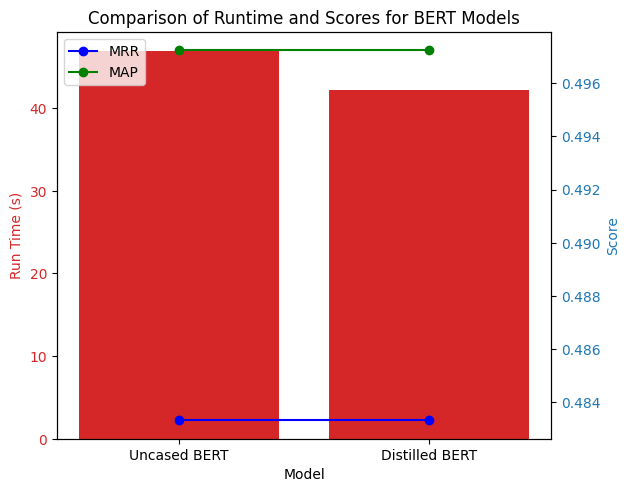

In [ ]:
import time

# Evaluation for Uncased BERT
start_time = time.time()
answers = []
for qa in articles_diction.values():
    answers.append(fetch_answer_from_article(qa['text'], qa['question']))
uncased_MRR, uncased_MAP = get_MRR_and_MAP_score(answers, correct_answers_list)
uncased_bert_time = time.time() - start_time
print("Evaluation for Uncased BERT")
print(f"MRR: {uncased_MRR}")
print(f"MAP: {uncased_MAP}")

# Evaluation for Distilled BERT
start_time = time.time()
answers = []
for qa in articles_diction.values():
    answers.append(fetch_answer_from_article(qa['text'], qa['question'], False))
distilled_MRR, distilled_MAP = get_MRR_and_MAP_score(answers, correct_answers_list)
distilled_bert_time = time.time() - start_time
print("Evaluation for Distilled BERT")
print(f"MRR: {distilled_MRR}")
print(f"MAP: {distilled_MAP}")

# Preparing data for plotting
labels = ['Uncased BERT', 'Distilled BERT']
times = [uncased_bert_time, distilled_bert_time]
MRR_scores = [uncased_MRR, distilled_MRR]
MAP_scores = [uncased_MAP, distilled_MAP]

# Creating subplots
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Model')
ax1.set_ylabel('Run Time (s)', color=color)
ax1.bar(labels, times, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Score', color=color)  # we already handled the x-label with ax1
ax2.plot(labels, MRR_scores, label='MRR', color='blue', marker='o')
ax2.plot(labels, MAP_scores, label='MAP', color='green', marker='o')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Comparison of Runtime and Scores for BERT Models')
plt.legend(loc='upper left')
plt.show()



In [ ]:
print(uncased_bert_time)
print(distilled_bert_time)

46.84906268119812
42.14881157875061


**TESTING - DATASET**

In [ ]:
sample_size = 1
random_sample = data.sample(n=sample_size, random_state=42)[['id', 'article']]
random_sample

,id,article
521,17904,Nominations for the 89th Academy Awards will b...


In [ ]:
question_list_for_sample = ["""When will the nominations for the 89th Academy Awards be announced?""", 
                            "Which Academy Awards will be announced on Tuesday?",
                            """How much has "Moonlight" earned over 14 weeks?""",
                            "What is the title of Martin Scorsese’s drama that needs the academy’s help to avoid a financial washout?",
                            "Who tried to rally his 101 million Facebook followers?",
                            """How much has "Silence" collected since its release on December 23?""",
                            """What is the setting for the film "Lion"?""",
                            "Which movie was the number one film in North America over the weekend?",
                            "How many additional ticket sales do Oscar nominations often result in? ",
                            """Which film arrived as a distant second after "Split"?"""]

In [ ]:
import pprint
id_to_find = random_sample["id"]
thetext = random_sample['article'].iloc[0]

article_test = {}

for i in range(1,len(question_list_for_sample)+1,1):
    the_text = thetext

    article_test[str(i)] = {"text": thetext, "question": question_list_for_sample[i - 1]}
pprint.pprint(article_test)

    


{'1': {'question': 'When will the nominations for the 89th Academy Awards be '
                   'announced?',
       'text': 'Nominations for the 89th Academy Awards will be announced on '
               'Tuesday, and movie marketers will be ready to pounce with ads '
               'that try to coax more people into seats: The establishment is '
               'swooning! Get to a theater! It works. Research indicates that '
               'Oscar nominations often result in tens of millions in '
               'additional ticket sales, particularly for     films. Among the '
               'movies counting on awards attention to find a bigger audience '
               'is ?Moonlight. ? Seen as a leading contender for best picture, '
               'this euphorically reviewed drama about a young black man in '
               'Miami started strong but has stalled. It has taken in about '
               '$15. 8 million over 14 weeks. For ?Silence,? Martin Scorsese '
               'and 

In [ ]:
correct_answer_for_system = [
    ["Tuesday", "on Tuesday","Tuesday"],
    ["89th","89th", "89th", "89th Academy Awards"],
    ["$15. 8 million","$15. 8 million","$15. 8"],
    ["silence","Silence","the movie Silence","Silence","silence"],
    ["Vin Diesel", "Vin Diesel", "Vin Diesel", "Vin Diesel","Vin Diesel"],
    ["$5. 2", "$5. 2 million"],
    ["India"],
    ["Split", "The movie split", "split"],
    ["10 millions", "ten of millions", "10 m", "10", "10 millions"],
    ["The Return of Xander Cage", "The Return of Xander Cage", "The Return of Xander Cage"]
]

In [ ]:
start_time = time.time()
answers_test_for_distilled_BERT= []
for qa in article_test.values():
    answers_test_for_distilled_BERT.append(fetch_answer_from_article(qa['text'], qa['question'], False))

MRR, MAP = get_MRR_and_MAP_score(answers_test_for_distilled_BERT, correct_answer_for_system)
print("Evaluation for Distilled BERT test")
print(f"MRR: {MRR}")
print(f"MAP: {MAP}")
test_time = time.time() - start_time
print(test_time)

Answer: tuesday
Answer: 89th academy awards
Answer: $ 15 . 8 million
Answer: silence
Answer: vin diesel
Answer: $ 5 . 2 million
Answer: india
Answer: the founder
Answer: tens of millions
Answer: xxx : the return of xander cage
Evaluation for Distilled BERT test
MRR: 0.425
MAP: 0.39708333333333334
62.246392488479614
